In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import xarray as xr
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
import seaborn_image as isns
import calendar
import string

In [2]:
import plotly.io as pio
pio.renderers.default='jupyterlab'

In [3]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [4]:
base_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_baseline_2.6_weighted.nc', decode_times=True)
oae_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_oae_2.6_weighted.nc', decode_times=True)

base_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/pH/ph_baseline_7.0_weighted.nc', decode_times=True)
oae_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/pH/ph_oae_7.0_weighted.nc', decode_times=True)

base_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_baseline_2.6_cropped.nc', decode_times=True)
oae_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_OAE_2.6_cropped.nc', decode_times=True)

base_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/pH/ph_baseline_7.0_cropped.nc', decode_times=True)
oae_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/pH/ph_OAE_7.0_cropped.nc', decode_times=True)

In [5]:
base_dp_26 = base_dp_26.where((3 < base_dp_26.nav_lon) & (base_dp_26.nav_lon < 3.1) & (52 < base_dp_26.nav_lat) & (base_dp_26.nav_lat < 53), drop=True)
oae_dp_26 = oae_dp_26.where((3 < oae_dp_26.nav_lon) & (oae_dp_26.nav_lon < 3.1) & (52 < oae_dp_26.nav_lat) & (oae_dp_26.nav_lat < 53), drop=True)

base_dp_70 = base_dp_70.where((3 < base_dp_70.nav_lon) & (base_dp_70.nav_lon < 3.1) & (52 < base_dp_70.nav_lat) & (base_dp_70.nav_lat < 53), drop=True)
oae_dp_70 = oae_dp_70.where((3 < oae_dp_70.nav_lon) & (oae_dp_70.nav_lon < 3.1) & (52 < oae_dp_70.nav_lat) & (oae_dp_70.nav_lat < 53), drop=True)

In [6]:
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [7]:
def annualavg(ph):
    ph = ph.sel(time_counter=slice('2090','2100'))
    ph = ph.sel(time=0).drop('time')
    month_length_baseline = ph.time_counter.dt.days_in_month
    ph = ((ph * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum()).to_dataframe()
    ph = (ph.groupby(ph.index.month).mean()).reset_index()
    ph['time_counter'] = ph['time_counter'].apply(lambda x: calendar.month_abbr[x])
    return(ph)

In [8]:
base_eu_26 = annualavg(base_eu_26)
oae_eu_26 = annualavg(oae_eu_26)
base_eu_70 = annualavg(base_eu_70)
oae_eu_70 = annualavg(oae_eu_70)

In [9]:
def annualavg_dp(ph):
    ph = ph.sel(time_counter=slice('2090','2100'))
    ph = (ph.ph.mean(dim=('x','y'))).to_dataset(name='ph')
    ph = ph.sel(time=0).drop('time')
    month_length_baseline = ph.time_counter.dt.days_in_month
    ph = ((ph * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum()).to_dataframe()
    ph = (ph.groupby(ph.index.month).mean()).reset_index()
    ph['time_counter'] = ph['time_counter'].apply(lambda x: calendar.month_abbr[x])
    return(ph)

In [10]:
base_dp_26 = annualavg_dp(base_dp_26)
oae_dp_26 = annualavg_dp(oae_dp_26)
base_dp_70 = annualavg_dp(base_dp_70)
oae_dp_70 = annualavg_dp(oae_dp_70)

In [11]:
def comp(oae, baseline):
    baseline = baseline.set_index('time_counter')
    oae = oae.set_index('time_counter')
    delta = (oae.ph - baseline.ph).to_xarray().to_dataframe('ph').reset_index()
    return(delta)

In [12]:
delta_mean_eu_26 = comp(oae_eu_26, base_eu_26)
delta_mean_eu_70 = comp(oae_eu_70, base_eu_70)
delta_mean_dp_26 = comp(oae_dp_26, base_dp_26)
delta_mean_dp_70 = comp(oae_dp_70, base_dp_70)

In [13]:
colors_month_ph = dict(zip(base_eu_26.time_counter.unique(), ['powderblue', 'darkcyan', 'forestgreen', 'darkseagreen', 
                                                        'honeydew', 'bisque', 'khaki', 'gold', 
                                                        'sandybrown', 'lightcoral', 'chocolate', 'cadetblue']))

In [14]:
def fig1(base, oae, delta):
    ax1.plot(base.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax1.plot(oae.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax1.scatter(base.time_counter, base.ph, color=base.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax1.scatter(oae.time_counter, oae.ph, color=oae.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax2.plot(delta.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax2.scatter(delta.time_counter, delta.ph, color=delta.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax1.tick_params(axis='y', which='major', labelsize=12)

In [15]:
def fig2(base, oae, delta):
    ax3.plot(base.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax3.plot(oae.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax3.scatter(base.time_counter, base.ph, color=base.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax3.scatter(oae.time_counter, oae.ph, color=oae.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax4.plot(delta.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax4.scatter(delta.time_counter, delta.ph, color=delta.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax3.tick_params(axis='y', which='major', labelsize=12)

In [16]:
def fig3(base, oae, delta):
    ax5.plot(base.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax5.plot(oae.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax5.scatter(base.time_counter, base.ph, color=base.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax5.scatter(oae.time_counter, oae.ph, color=oae.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax6.plot(delta.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax6.scatter(delta.time_counter, delta.ph, color=delta.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax5.tick_params(axis='y', which='major', labelsize=12)

In [17]:
def fig4(base, oae, delta):
    ax7.plot(base.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax7.plot(oae.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax7.scatter(base.time_counter, base.ph, color=base.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax7.scatter(oae.time_counter, oae.ph, color=oae.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax8.plot(delta.ph, '-', color="black", linewidth=0.5, zorder=1)
    ax8.scatter(delta.time_counter, delta.ph, color=delta.time_counter.map(lambda x: colors_month_ph[x]), edgecolors='black',  linewidth=0.5, s=30)
    ax7.tick_params(axis='y', which='major', labelsize=12)

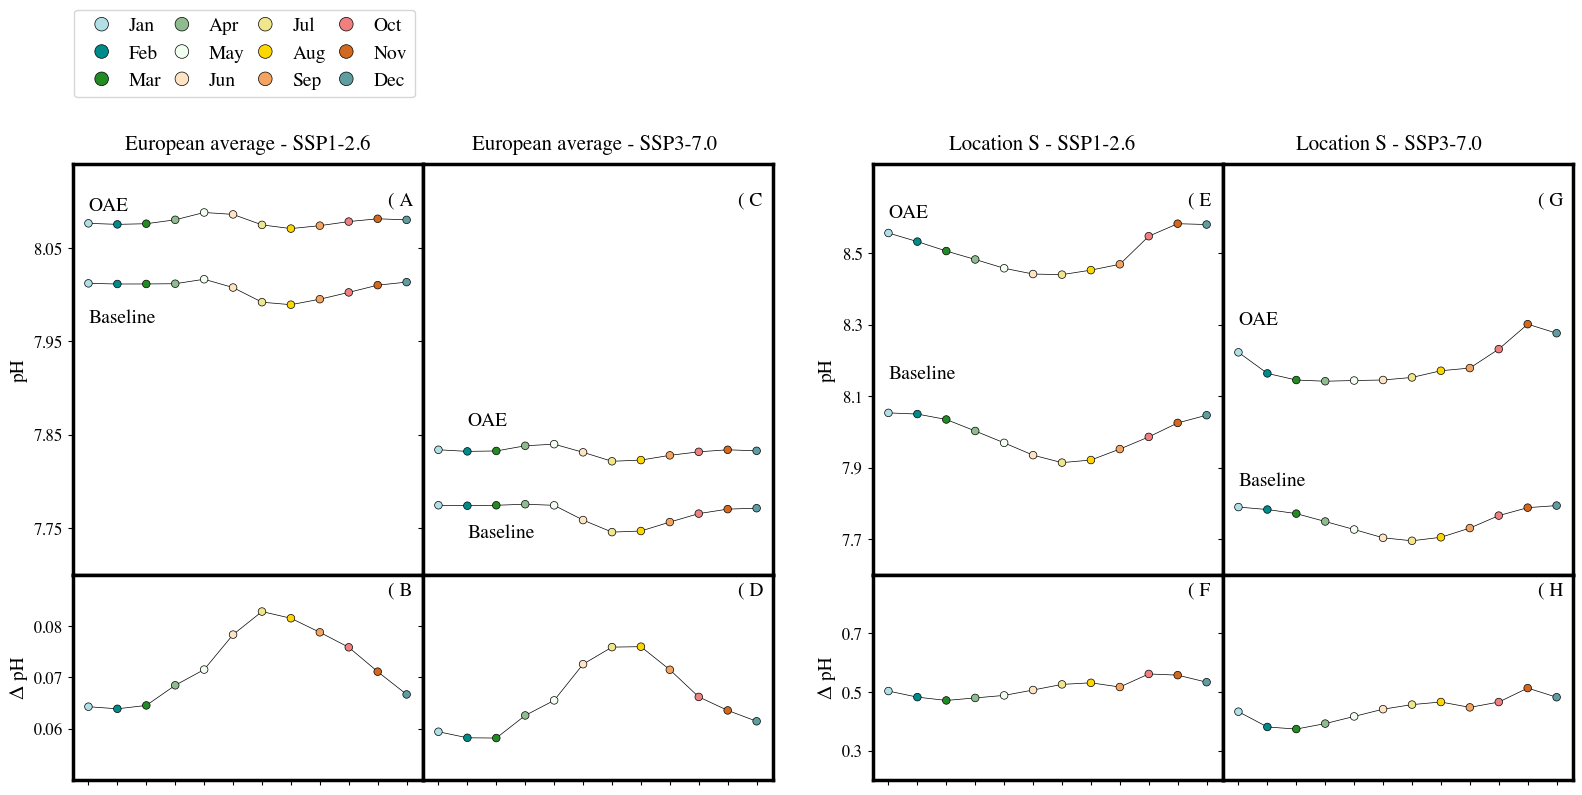

In [19]:
f = plt.figure(figsize=(20, 8)) 
gs_left = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])
gs_right = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])

ax1 = plt.subplot(gs_left[0,0])
ax2 = plt.subplot(gs_left[1,0])
ax3 = plt.subplot(gs_left[0,1], sharey = ax1)
ax4 = plt.subplot(gs_left[1,1], sharey = ax2)
ax5 = plt.subplot(gs_right[0,2])
ax6 = plt.subplot(gs_right[1,2])
ax7 = plt.subplot(gs_right[0,3], sharey = ax5)
ax8 = plt.subplot(gs_right[1,3], sharey = ax6)

gs_left.update(wspace=0, hspace=0, left=0, right=0.7)
gs_right.update(wspace=0, hspace=0, left=0.05, right=0.75)

fig1(base_eu_26, oae_eu_26, delta_mean_eu_26)
fig2(base_eu_70, oae_eu_70, delta_mean_eu_70)
fig3(base_dp_26, oae_dp_26, delta_mean_dp_26)
fig4(base_dp_70, oae_dp_70, delta_mean_dp_70)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.tick_params(axis='y', which='major', labelsize=12)
for n, ax in enumerate(axes):
    ax.text(0.9, 0.9, string.punctuation[7] + ' ' + string.ascii_uppercase[n], transform=ax.transAxes, 
            size=14, weight='bold', color='black')

ax1.set_ylabel('pH', fontsize=14)
ax2.set_ylabel('Δ pH', fontsize=14)
ax5.set_ylabel('pH', fontsize=14)
ax6.set_ylabel('Δ pH', fontsize=14)

ax1.text(0, 7.97, s='Baseline', fontsize=14)
ax1.text(0, 8.09, s='OAE', fontsize=14)
ax3.text(1, 7.74, s='Baseline', fontsize=14)
ax3.text(1, 7.86, s='OAE', fontsize=14)
ax5.text(0, 8.15, s='Baseline', fontsize=14)
ax5.text(0, 8.60, s='OAE', fontsize=14)
ax7.text(0, 7.85, s='Baseline', fontsize=14)
ax7.text(0, 8.3, s='OAE', fontsize=14)

start1, end1 = ax1.set_ylim(7.70, 8.14)
ax1.yaxis.set_ticks(np.arange(start1+0.05, end1, 0.1))
start2, end2 = ax2.set_ylim(0.05, 0.09)
ax2.yaxis.set_ticks(np.arange(start2+0.01, end2, 0.01))
start5, end5 = ax5.set_ylim(7.6, 8.75)
ax5.yaxis.set_ticks(np.arange(start5+0.1, end5-0.1, 0.2))
start6, end6 = ax6.set_ylim(0.2, 0.9)
ax6.yaxis.set_ticks(np.arange(start6+0.1, end6, 0.2))

axtick = [ax3, ax4, ax7, ax8]
for ax in axtick:
    ax.yaxis.set_tick_params(labelleft=False)
    
ax.text(-38.5,2.35, 'European average - SSP1-2.6')
ax.text(-26.5,2.35, 'European average - SSP3-7.0')
ax.text(-10,2.35, 'Location S - SSP1-2.6')
ax.text(2,2.35, 'Location S - SSP3-7.0')

legend = [mpatches.Circle((0.5, 0.5), 1, facecolor = value, edgecolor = "black", linewidth=0.5, label = key, alpha = 1) for key, value in colors_month_ph.items()]
ax.legend(handles = legend, bbox_to_anchor=(-2.28,3.8), loc='best', columnspacing=0.05, handletextpad=0.4, fontsize=14, ncol = 4, handler_map={mpatches.Circle: HandlerEllipse()})

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/seasonal_analysis/final_figs/ph.png')